# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [19]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
import scmemo, utils

In [9]:
data_path = '/data/parameter_estimation/interferon_data/20200412/'

### Perform some basic filtering

In [10]:
def simplify_name(name):
    return name.split('.')[0]

In [11]:
adata = sc.read(data_path + 'interferon_highcount.raw.h5ad')
adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [12]:
known_gene_df = pd.read_csv(data_path + 'chipseq/gene_locations_2.bed', header=0, sep='\t')#[[4, 5]]
known_gene_df['gene_name'] = known_gene_df['transcript'].apply(simplify_name)
known_gene_df['gene_ids'] = known_gene_df['protein'].apply(simplify_name)

In [13]:
new_var = adata.var.merge(known_gene_df, on='gene_ids', how='left')
new_var.index = adata.var.index
adata.var = new_var.copy()

In [14]:
adata.obs.cell.value_counts()

CD4 T cells          10389
CD14+ Monocytes      5385 
B cells              2573 
CD8 T cells          2042 
NK cells             1993 
FCGR3A+ Monocytes    1599 
Dendritic cells      432  
Megakaryocytes       260  
Name: cell, dtype: int64

In [15]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

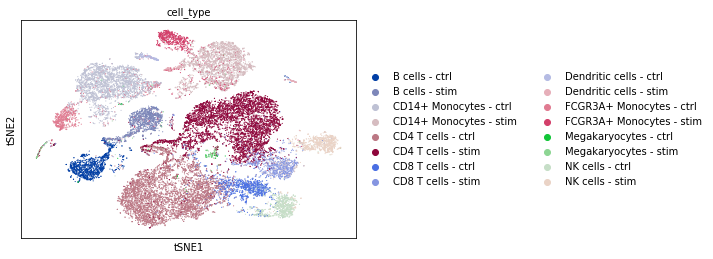

In [20]:
sc.pl.tsne(adata, color='cell_type')

In [17]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [18]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 3593


### Some useful functions

In [48]:
def density_scatterplot(a,b, s=1, cmap='Reds', kde=None):
    # Calculate the point density
    condition = np.isfinite(a) & np.isfinite(b)
    x = a[condition]
    y = b[condition]
    xy = np.vstack([x,y])
    z = stats.gaussian_kde(xy, bw_method=kde)(xy)
    print(z)
    plt.scatter(x, y, c=z, s=s, edgecolor='', cmap=cmap)
    

def robust_correlation(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    return stats.spearmanr(x,y)

def robust_linregress(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    print(x.min())
    
    return stats.linregress(x,y)

def robust_hist(x, **kwargs):
    
    condition = np.isfinite(x)
    plt.hist(x[condition], **kwargs)

### Select immune genes using GO annotations

In [286]:
go_annotations = pd.read_csv(data_path + '../../GO_annotations-9606-inferred-allev.tsv', sep='\t')
go_annotations['gene'] = go_annotations['gene_symbols'].apply(lambda x: x.split('|'))
go_annotations = go_annotations\
    .query('go_domain == "biological_process"')\
    .explode('gene')[['go_name', 'gene']]

In [287]:
immune_genes = go_annotations[go_annotations.go_name.str.contains('immune')].gene.drop_duplicates().tolist()

In [288]:
genes_of_interest = list(set(adata.var.index) & set(immune_genes))

In [289]:
with open(data_path + 'immune_genes.pkl', 'wb') as f:
    pkl.dump(genes_of_interest, f)

### Observed $\mu$-$CV^{2}$ Relationship

In [31]:
imp.reload(scmemo)
estimator = scmemo.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)
estimator.compute_observed_moments()

In [32]:
estimator.estimate_beta_sq(tolerance=3)

In [33]:
estimator.estimate_1d_parameters()

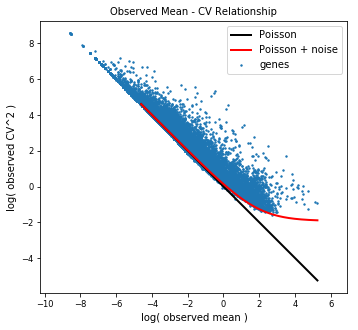

In [34]:
estimator.plot_cv_mean_curve()
#plt.savefig(data_path + 'figures/observed_cv_vs_mean.png', bbox_inches='tight')

### Residual variance

In [32]:
est_mean = np.concatenate([estimator.estimated_central_moments[ct]['first'] for ct in estimator.groups])
est_var = np.concatenate([estimator.estimated_central_moments[ct]['second'] for ct in estimator.groups])
est_disp = est_var/est_mean
est_cv = est_var/est_mean**2

[0.17763623 0.01312534 0.00042334 ... 0.11071346 0.01763778 0.0769338 ]


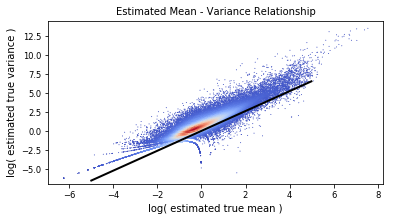

In [35]:
plt.figure(figsize=(6, 3))
density_scatterplot(
    np.log(est_mean),
    np.log(est_var),
    s=1, 
    cmap='coolwarm')
x_fit = np.arange(-5, 5, 0.01)
y_fit = x_fit*estimator.mean_var_slope
plt.plot(x_fit, y_fit, color='k', lw=2)
plt.ylim(-7,)
plt.title('Estimated Mean - Variance Relationship');
plt.xlabel('log( estimated true mean )')
plt.ylabel('log( estimated true variance )')
plt.savefig('mean_vs_var.png', bbox_inches='tight')

[0.17763622 0.01312534 0.00042334 ... 0.11071347 0.01763778 0.07693379]


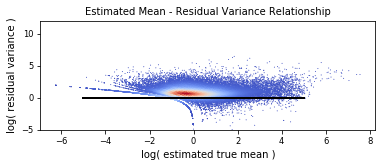

In [36]:
plt.figure(figsize=(6, 2))
density_scatterplot(
    np.log(est_mean),
    np.log(est_var) - estimator.mean_var_slope*np.log(est_mean),
    s=1, 
    cmap='coolwarm')
plt.plot([-5, 5], np.array([0, 0]), color='k', lw=2)
plt.ylim(-5,12)
plt.title('Estimated Mean - Residual Variance Relationship');
plt.xlabel('log( estimated true mean )')
plt.ylabel('log( residual variance )')
plt.savefig('mean_vs_res_var.png', bbox_inches='tight')

## Effect of interferon stimulation across cell types

### Read 1D Hypothesis test results and confidence intervals

Make sure that p values are well calibrated.

In [33]:
def get_key(ct):
    return (ct + ' - ctrl', ct + ' - stim')

In [34]:
with open(data_path + 'stim_effect_1d_params.pkl', 'rb') as f:
    parameter_dict = pkl.load(f)
with open(data_path + 'stim_effect_ci_1d.pkl', 'rb') as f:
    ci_dict = pkl.load(f)
with open(data_path + 'stim_effect_1d.pkl', 'rb') as f:
    test_dict = pkl.load(f)

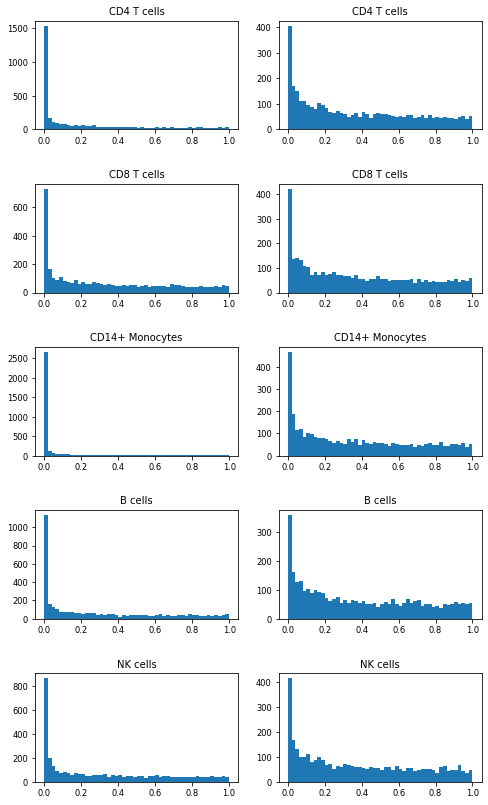

In [79]:
plt.figure(figsize=(8, 14))
plt.subplots_adjust(hspace=0.5)

for idx, ct in enumerate(['CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells']):
    
    plt.subplot(5, 2, 2*idx+1);
    plt.hist(test_dict[get_key(ct)]['de_pval'], bins=50);
    plt.title('{}'.format(ct))
    
    plt.subplot(5, 2, 2*idx+2);
    plt.hist(test_dict[get_key(ct)]['dv_pval'], bins=50);
    plt.title('{}'.format(ct))
plt.savefig('de_dv_calibration.pdf', bbox_inches='tight')

### ISGF3 vs Rest of upregulated genes 

Data from CHIP-seq

In [57]:
# Read the all gene information
window_size = 1000
gene_sites = pd.read_csv('all_gene_locations_2.bed', sep='\t')
gene_sites['tss_site'] = gene_sites['txStart']*(gene_sites['strand'] == '+') + gene_sites['txEnd']*(gene_sites['strand'] == '-')
gene_sites['tss_window_start'] = gene_sites['tss_site'] - int(window_size/2)
gene_sites['tss_window_end'] = gene_sites['tss_site'] + int(window_size/2)
gene_sites['tss_window_start'] = gene_sites['tss_window_start']*(gene_sites['tss_window_start'] > 0)

gene_sites['gene_name'] = gene_sites['#name'].apply(simplify_name)

gene_sites = gene_sites[['chrom', 'tss_window_start', 'tss_window_end', 'gene_name']].sort_values(['chrom', 'tss_window_start'])
gene_sites.to_csv(data_path + 'chipseq/gene_tss_windows_{}.bed'.format(window_size), index=False, header=False, sep='\t')

In [58]:
!/home/mkim7/tools/bedtools closest \
    -a /data/parameter_estimation/interferon_data/20200412/chipseq/isgf3/stat1_stat2_intersect_6hr.sorted.bed \
    -b /data/parameter_estimation/interferon_data/20200412/chipseq/gene_tss_windows_1000.bed -d  > \
    /data/parameter_estimation/interferon_data/20200412/chipseq/isgf3/isgf3_genes.bed

In [62]:
highcount_genes = adata.var.copy()
highcount_genes['gene'] = highcount_genes.index.tolist()

In [63]:
isgf3_df = pd.read_csv(data_path + 'chipseq/isgf3/isgf3_genes.bed', sep='\t', header=None).iloc[:, [-2, -1]]
isgf3_df.columns=['gene_name', 'distance']
isgf3_df = isgf3_df.query('distance == 0')
isgf3_df = isgf3_df.merge(highcount_genes[['gene_name', 'gene_ids', 'gene']], on='gene_name', how='inner')
isgf3_genes = isgf3_df['gene'].drop_duplicates().tolist()

In [64]:
len(isgf3_genes)

112

In [55]:
ct_dfs = []
for ct in ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']:
    
    # Get upregulated genes
    upreg_genes = utils.get_differential_genes(
        gene_list=adata.var.index.tolist(),
        hypothesis_test_dict=test_dict,
        group_1 = get_key(ct)[0],
        group_2 = get_key(ct)[1],
        which='mean',
        direction='increase',
        sig=0.05,
        num_genes=5000
        )['gene'].tolist()
    
    # Filter the stat list
    isgf3_upreg_genes = list(set(isgf3_genes) & set(upreg_genes))
    isgf3_upreg_idxs = np.where(np.isin(adata.var.index, isgf3_upreg_genes))[0]
    
    # Get the remaining upreg genes
    upreg_genes = list(set(upreg_genes) - set(isgf3_upreg_genes))
    upreg_gene_idxs = np.where(np.isin(adata.var.index, upreg_genes))[0]
    
    
    dv_diffs_isre_gas = test_dict[get_key(ct)]['dv_diff'][isgf3_upreg_idxs]
    dv_fdr_isre_gas = test_dict[get_key(ct)]['dv_fdr'][isgf3_upreg_idxs]
    dv_diffs_upreg = test_dict[get_key(ct)]['dv_diff'][upreg_gene_idxs]
    dv_fdr_upreg = test_dict[get_key(ct)]['dv_fdr'][upreg_gene_idxs]
    
    dv_diffs_isre_gas = dv_diffs_isre_gas#[dv_fdr_isre_gas < 1]
    dv_diffs_upreg = dv_diffs_upreg#[dv_fdr_upreg < 1]
    
    isre_gas_df = pd.DataFrame()
    isre_gas_df['dv_diff'] = dv_diffs_isre_gas
    isre_gas_df['dv_fdr'] = dv_fdr_isre_gas
    isre_gas_df['type'] = 'ISGF3'
    
    upreg_df = pd.DataFrame()
    upreg_df['dv_diff'] = dv_diffs_upreg
    upreg_df['dv_fdr'] = dv_fdr_upreg
    upreg_df['type'] = 'upregulated'
    
    combined_df = pd.concat([isre_gas_df, upreg_df])
    combined_df['cell_type'] = ct
    ct_dfs.append(combined_df.copy())
    
    print('---')
    print(len(isgf3_upreg_genes), len(upreg_genes))
    
#     plt.figure()
#     sns.distplot(dv_diffs_isre_gas[np.isfinite(dv_diffs_isre_gas)])
#     sns.distplot(dv_diffs_upreg[np.isfinite(dv_diffs_upreg)])
    print(
        dv_diffs_isre_gas[np.isfinite(dv_diffs_isre_gas)].mean(),
        dv_diffs_upreg[np.isfinite(dv_diffs_upreg)].mean(),
        ct, 
        stats.ks_2samp(
            dv_diffs_isre_gas[np.isfinite(dv_diffs_isre_gas)], 
            dv_diffs_upreg[np.isfinite(dv_diffs_upreg)]))
isgf3_comparison_df = pd.concat(ct_dfs)
#cts = ['CD4 T cells', 'CD8 T cells', 'NK cells', 'B cells', 'CD14+ Monocytes', 'FCGR3A+ Monocytes']

#isre_gas_comparison_df = isre_gas_comparison_df[isre_gas_comparison_df['cell_type'].isin(cts)]

---
97 695
-0.4358675948323177 -0.07780981602414838 CD4 T cells Ks_2sampResult(statistic=0.2178891937995995, pvalue=0.0004940516162844633)
---
92 761
-0.5697441639968354 -0.12131583551452008 CD14+ Monocytes Ks_2sampResult(statistic=0.41265830096316297, pvalue=5.324629626102251e-13)
---
90 599
-0.3748798769425845 0.09229001484702916 FCGR3A+ Monocytes Ks_2sampResult(statistic=0.3017992951214988, pvalue=8.187851890939513e-07)
---
83 346
-0.3304594423197727 0.07807429808088183 NK cells Ks_2sampResult(statistic=0.2604289992339299, pvalue=0.00017071211704966505)
---
84 308
-0.15252208538195708 0.07177648362295204 CD8 T cells Ks_2sampResult(statistic=0.19805194805194806, pvalue=0.009721818211038347)
---
94 456
-0.16231873959248488 -0.0029129079587816805 B cells Ks_2sampResult(statistic=0.13461179544606197, pvalue=0.10688196678371187)


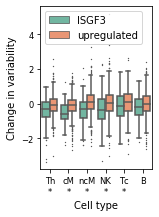

In [49]:
plt.figure(figsize=(2, 3))
sns.boxplot(
    x='cell_type', y='dv_diff', hue='type',
    data=isgf3_comparison_df,
    palette=sns.color_palette('Set2'),
    fliersize=0.5)
#plt.plot([-1, 6], [0, 0], '--', lw=1, color='k')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['Th\n*', 'cM\n*', 'ncM\n*', 'NK\n*', 'Tc\n*', 'B'])
plt.xlabel('Cell type'); plt.ylabel('Change in variability');
plt.legend(loc='upper left')
plt.savefig('isgf3_vs_rest.pdf', bbox_inches='tight')

### Compile 1D hypothesis testing result

In [38]:
def create_1d_df(adata, ct, test_dict):
    
    df = pd.DataFrame()
    gene_list = adata.var.index
    df['gene'] = gene_list
    df['ct'] = ct
    
    for key,val in test_dict[get_key(ct)].items():
        df[key] = val
        
    return df

def assign_quadrant(row):
    
    if row['de_diff'] > 0 and row['dv_diff'] > 0:
        return 'upper_right'
    elif row['de_diff'] > 0 and row['dv_diff'] < 0:
        return 'lower_right'
    elif row['de_diff'] < 0 and row['dv_diff'] > 0:
        return 'upper_left'
    elif row['de_diff'] < 0 and row['dv_diff'] < 0:
        return 'lower_left'
    else:
        return 'None'

In [39]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
df = pd.concat([create_1d_df(adata, ct, test_dict) for ct in cts])
df['quadrant'] = df.apply(assign_quadrant, axis=1)

### Find an example 

Preferably one that is from the ISGF3 analysis

In [40]:
isgf3_df = df.query('gene in @isgf3_genes & de_fdr < 0.05 & ct != "B cells" & dv_fdr < 0.1')
dv_upreg_df = df.query('de_fdr < 0.05 & de_diff > 0 & dv_diff > 0 & dv_fdr < 0.1 & ct != "B cells" & log_mean_1 < 0.1 & log_mean_2 > 1')

In [41]:
dv_upreg_df.shape

(11, 13)

In [42]:
dv_upreg_df.sort_values('log_residual_var_2', ascending=False).head(20)

,gene,ct,log_mean_1,log_mean_2,log_residual_var_1,log_residual_var_2,de_diff,de_pval,de_fdr,dv_diff,dv_pval,dv_fdr,quadrant
2938,CCL8,NK cells,-4.517431,1.063654,0.589808,4.547885,5.581085,4.258095e-07,9.654424e-06,3.958076,6.999965e-05,0.006230,upper_right
2960,CCR7,CD14+ Monocytes,0.081008,1.003174,1.918561,2.890957,0.922166,7.082337e-07,1.962679e-06,0.972396,1.865636e-07,0.000058,upper_right
914,CXCL10,CD4 T cells,-3.761394,1.702511,0.332498,2.881376,5.463904,1.189304e-08,4.008142e-07,2.548878,1.122299e-06,0.000339,upper_right
178,GBP1,NK cells,-1.221594,1.223282,-0.776269,1.272165,2.444876,3.027815e-08,3.068842e-06,2.048434,2.020835e-06,0.000656,upper_right
2006,IFITM3,CD4 T cells,-1.484126,1.618188,0.393508,1.055410,3.102314,4.057742e-08,7.213540e-07,0.661903,2.799986e-04,0.016483,upper_right
831,TNFSF10,CD4 T cells,-0.708967,2.383737,-0.002926,0.949470,3.092704,4.731520e-08,7.755796e-07,0.952396,1.408640e-06,0.000339,upper_right
878,CD38,FCGR3A+ Monocytes,-1.904818,1.782023,-0.374698,0.915567,3.686840,1.731562e-07,2.420144e-06,1.290265,1.061335e-06,0.000347,upper_right
1637,DEFB1,FCGR3A+ Monocytes,-2.356803,2.227761,-0.172327,0.886957,4.584563,9.197490e-08,1.766705e-06,1.059284,2.933660e-06,0.000547,upper_right
164,IFI44L,CD8 T cells,-1.793609,1.609441,-0.433793,0.591701,3.403050,1.344621e-07,7.238546e-06,1.025494,6.999965e-05,0.006377,upper_right
309,BLZF1,FCGR3A+ Monocytes,-0.806206,1.394980,-1.142148,0.286738,2.201186,3.189186e-07,3.291902e-06,1.428885,3.999980e-05,0.002874,upper_right


In [44]:
['TNFSF10', 'OAS1']
['CD38', 'TRIM22']

['CD38', 'TRIM22']

In [45]:
ct = 'CD4 T cells'
val = 2.383737
diff = 0.2
isgf3_df.query('ct == "{}" & log_mean_2 > {} & log_mean_2 < {}'.format(ct, val-diff, val+diff))#.sort_values('log_mean_2', ascending=False).head(30)

,gene,ct,log_mean_1,log_mean_2,log_residual_var_1,log_residual_var_2,de_diff,de_pval,de_fdr,dv_diff,dv_pval,dv_fdr,quadrant
164,IFI44L,CD4 T cells,-1.110501,2.196949,1.418137,-0.179025,3.307451,9.916067e-09,3.788148e-07,-1.597162,0.000003,0.000548,lower_right
831,TNFSF10,CD4 T cells,-0.708967,2.383737,-0.002926,0.949470,3.092704,4.731520e-08,7.755796e-07,0.952396,0.000001,0.000339,upper_right
2394,OAS1,CD4 T cells,-1.235664,2.252761,0.750926,-0.215651,3.488425,2.717336e-06,1.527066e-05,-0.966576,0.000050,0.004604,lower_right


In [46]:
ct = 'FCGR3A+ Monocytes'
val = 1.782023
diff = 0.2
isgf3_df.query('ct == "{}" & log_mean_2 > {} & log_mean_2 < {}'.format(ct, val-diff, val+diff))#.sort_values('log_mean_2', ascending=False).head(30)

,gene,ct,log_mean_1,log_mean_2,log_residual_var_1,log_residual_var_2,de_diff,de_pval,de_fdr,dv_diff,dv_pval,dv_fdr,quadrant
2027,TRIM22,FCGR3A+ Monocytes,-0.040033,1.679053,0.291577,-0.848155,1.719086,1.783448e-07,0.000002,-1.139731,0.00413,0.068364,lower_right


### Get numbers for the paper

In [26]:
df_de_sig = df.query('de_fdr < 0.05')
df_de_sig.to_csv('de_hits.csv', index=False)
df_de_sig.gene.drop_duplicates().shape

(3216,)

In [62]:
df_de_sig.groupby('ct').size()

ct
B cells              1078
CD14+ Monocytes      2766
CD4 T cells          1558
CD8 T cells          593 
FCGR3A+ Monocytes    1810
NK cells             760 
dtype: int64

In [59]:
df_dv_sig = df.query('dv_fdr < 0.1')
df_dv_sig.to_csv('dv_hits.csv', index=False)
df_dv_sig.gene.drop_duplicates().shape

(1244,)

In [63]:
df_de_sig.groupby('ct').size()

ct
B cells              1078
CD14+ Monocytes      2766
CD4 T cells          1558
CD8 T cells          593 
FCGR3A+ Monocytes    1810
NK cells             760 
dtype: int64

### Compare DE result with demuxlet paper

In [85]:
#!pip install xlrd

In [90]:
sheet_names = ['cd14', 'cd4', 'cd8', 'nk', 'cd16 mono', 'cd19']
name_to_ct = dict(zip(
    sheet_names,
    ['CD14+ Monocytes','CD4 T cells','CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'B cells']
))
dfs = []
for name in sheet_names:
    demux_de_df = pd.read_excel(
        '41587_2018_BFnbt4042_MOESM4_ESM.xlsx', 
        sheet_name=name,
        index_col=0)[['log2FoldChange', 'featureData.symbol']]
    demux_de_df.columns = ['logfc_demux', 'gene']
    demux_de_df['ct'] = name_to_ct[name]
    dfs.append(demux_de_df.copy())
df = pd.concat(dfs)

In [97]:
combined = df.merge(df_de_sig[['ct', 'gene', 'de_diff']], on=['ct', 'gene'], how='inner')

In [98]:
combined.head(5)

,logfc_demux,gene,ct,de_diff
0,4.613688,IFITM2,CD14+ Monocytes,3.096794
1,3.296659,SSB,CD14+ Monocytes,2.122777
2,5.529914,NT5C3A,CD14+ Monocytes,3.800217
3,6.284821,IL1RN,CD14+ Monocytes,4.302417
4,5.708423,RABGAP1L,CD14+ Monocytes,4.014697


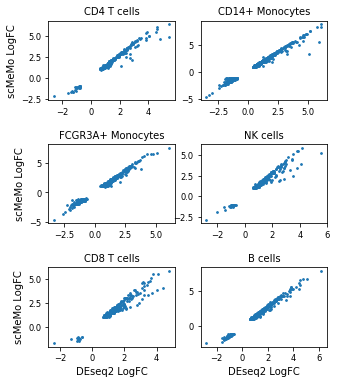

In [119]:
plt.figure(figsize=(5, 6))
plt.subplots_adjust(hspace=0.55)
for idx, ct in enumerate(cts):
    
    plt.subplot(3, 2, idx+1)
    data = combined.query('ct == "{}"'.format(ct))
    plt.scatter(data.de_diff, data.logfc_demux, s=3)
    plt.title(ct)
    
    if idx == 5 or idx == 4:
        plt.xlabel('DEseq2 LogFC')
    if idx % 2 == 0:
        plt.ylabel('scMeMo LogFC')
plt.savefig('de_comparison.pdf', bbox_inches='tight')

### Figure out some overall trends regarding the quadrants

- upregulated & decreased variance: ISRE, ISGs
- upregulated & increased variance: metabolism, apoptosis, protein breakdown
- downregulated & increased variance: ribosomal proteins

In [27]:
df_sig = df.query('de_fdr < 0.05 & dv_fdr < 0.1')
upper_right = df_sig.query('de_diff > 0 & dv_diff > 0')
upper_right = upper_right.groupby('gene')['ct'].apply(list).reset_index(name='ur_cts')
upper_right['ur_count'] = upper_right['ur_cts'].apply(lambda x: len(x))

lower_right = df_sig.query('de_diff > 0 & dv_diff < 0')
lower_right = lower_right.groupby('gene')['ct'].apply(list).reset_index(name='lr_cts')
lower_right['lr_count'] = lower_right['lr_cts'].apply(lambda x: len(x))

quadrants = lower_right.merge(upper_right, on='gene')

In [30]:
df_sig.query('quadrant == "upper_right"').groupby('gene')\
    .size().sort_values(ascending=False).head(10)

gene
SAT1       5
PRF1       3
TNFSF10    3
ZC3HAV1    2
CASP3      2
GALM       2
FCER1G     2
RNF138     2
IFITM3     2
SOCS3      2
dtype: int64

In [31]:
df_sig.query('quadrant == "lower_right"').groupby('gene')\
    .size().sort_values(ascending=False).head(10)

gene
IFI6      5
IFIT1     4
LY6E      4
MX1       4
IFI44L    4
RSAD2     3
HERC5     3
MNDA      3
OAS3      3
OASL      3
dtype: int64

In [32]:
df_sig.query('quadrant == "upper_left"').groupby('gene')\
    .size().sort_values(ascending=False).head(10)

gene
RPL6       3
RPS7       3
CXCR4      3
RNF126     2
TIMP1      2
RPL10      2
RPL10A     2
CD52       2
GPX4       2
PTPRCAP    2
dtype: int64

### GSEA analysis with EnrichR

In [33]:
import gseapy

In [34]:
dec_var_genes = df_sig.query('quadrant == "lower_right"').gene.tolist()
inc_var_genes = df_sig.query('quadrant == "upper_right"').gene.tolist()

In [35]:
gseapy.enrichr(
    gene_list=dec_var_genes,
    description='pathway',
    gene_sets='KEGG_2019_Human')
dec_var_gsea = pd.read_csv('Enrichr/KEGG_2019_Human.pathway.enrichr.reports.txt', sep='\t')

In [36]:
dec_var_gsea.sort_values('Adjusted P-value').head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Human,Influenza A,15/171,4.640759e-11,1.429354e-08,0,0,9.692740,230.624776,RSAD2;MX1;EIF2AK2;PML;IFIH1;CXCL10;OAS1;OAS2;OAS3;TNFSF10;CASP1;IRF7;CYCS;CCL2;FAS
1,KEGG_2019_Human,NOD-like receptor signaling pathway,14/178,8.922737e-10,1.374101e-07,0,0,8.690794,181.092231,GSDMD;GBP5;GBP7;AIM2;OAS1;OAS2;OAS3;CASP4;CASP1;IRF7;CCL2;RBCK1;CARD16;GBP4
2,KEGG_2019_Human,Hepatitis C,12/155,1.765182e-08,1.812253e-06,0,0,8.554625,152.720817,CXCL10;RSAD2;OAS1;OAS2;OAS3;MX1;IRF7;EIF2AK2;CYCS;FAS;BAK1;IFIT1
3,KEGG_2019_Human,Epstein-Barr virus infection,12/201,3.083592e-07,2.374366e-05,0,0,6.596850,98.899979,CXCL10;GADD45B;OAS1;OAS2;OAS3;IRF7;FAS;EIF2AK2;CYCS;ISG15;BAK1;RUNX3
4,KEGG_2019_Human,Measles,10/138,5.226358e-07,3.219436e-05,0,0,8.007046,115.816967,IFIH1;OAS1;OAS2;OAS3;MX1;IRF7;EIF2AK2;CYCS;FAS;BAK1
5,KEGG_2019_Human,Human immunodeficiency virus 1 infection,9/212,1.389520e-04,7.132870e-03,0,0,4.690920,41.661856,BST2;GNG5;TRIM5;GNB4;FAS;CYCS;BAK1;SAMHD1;APOBEC3A
8,KEGG_2019_Human,Apoptosis,7/143,3.290528e-04,1.126092e-02,0,0,5.408956,43.375997,GADD45B;TNFSF10;PMAIP1;CYCS;FAS;BAK1;MCL1
7,KEGG_2019_Human,Kaposi sarcoma-associated herpesvirus infection,8/186,2.994021e-04,1.152698e-02,0,0,4.752569,38.561031,ZFP36;GNG5;GNB4;IRF7;FAS;EIF2AK2;CYCS;BAK1
6,KEGG_2019_Human,Cytosolic DNA-sensing pathway,5/63,2.640068e-04,1.161630e-02,0,0,8.769622,72.257615,CXCL10;AIM2;TREX1;CASP1;IRF7
9,KEGG_2019_Human,Herpes simplex virus 1 infection,13/492,5.610573e-04,1.728056e-02,0,0,2.919642,21.855531,SP100;EIF2AK2;PML;BST2;IFIH1;OAS1;OAS2;OAS3;IRF7;FAS;CYCS;CCL2;BAK1


In [37]:
gseapy.enrichr(
    gene_list=inc_var_genes,
    description='pathway',
    gene_sets='KEGG_2019_Human')
inc_var_gsea = pd.read_csv('Enrichr/KEGG_2019_Human.pathway.enrichr.reports.txt', sep='\t')

In [38]:
inc_var_gsea.sort_values('Adjusted P-value').head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
1,KEGG_2019_Human,Tuberculosis,9/179,1.440134e-06,0.000222,0,0,8.310633,111.784448,FCGR2A;FCER1G;CASP3;CALM1;CTSD;RELA;MYD88;HLA-DRB1;HLA-DPA1
5,KEGG_2019_Human,TNF signaling pathway,7/110,4.735561e-06,0.000243,0,0,10.518407,128.959988,SOCS3;CXCL10;CASP3;IRF1;CCL2;MAP3K8;RELA
3,KEGG_2019_Human,Allograft rejection,5/38,3.190962e-06,0.000246,0,0,21.748586,275.232452,PRF1;GZMB;FASLG;HLA-DRB1;HLA-DPA1
2,KEGG_2019_Human,Apoptosis,8/143,2.556718e-06,0.000262,0,0,9.246951,119.071015,CASP3;PRF1;TNFSF10;GZMB;FASLG;CTSD;RELA;CTSC
6,KEGG_2019_Human,Type I diabetes mellitus,5/43,5.973504e-06,0.000263,0,0,19.219681,231.177723,PRF1;GZMB;FASLG;HLA-DRB1;HLA-DPA1
4,KEGG_2019_Human,Graft-versus-host disease,5/41,4.695585e-06,0.000289,0,0,20.157226,247.306750,PRF1;GZMB;FASLG;HLA-DRB1;HLA-DPA1
0,KEGG_2019_Human,Influenza A,9/171,9.840091e-07,0.000303,0,0,8.699435,120.327366,CXCL10;SOCS3;TNFSF10;CCL2;FASLG;RELA;MYD88;HLA-DRB1;HLA-DPA1
7,KEGG_2019_Human,Natural killer cell mediated cytotoxicity,7/131,1.495928e-05,0.000576,0,0,8.832250,98.127882,TYROBP;FCER1G;CASP3;PRF1;TNFSF10;GZMB;FASLG
8,KEGG_2019_Human,Autoimmune thyroid disease,5/53,1.696936e-05,0.000581,0,0,15.593326,171.278675,PRF1;GZMB;FASLG;HLA-DRB1;HLA-DPA1
9,KEGG_2019_Human,Staphylococcus aureus infection,5/68,5.734298e-05,0.001766,0,0,12.153622,118.697863,FCGR2A;DEFB1;FPR3;HLA-DRB1;HLA-DPA1


### Export DV values for GSEA in R

In [46]:
df.to_csv('upreg_genes.csv', index=False)

### Quadrant scatterplots for each cell type

In [62]:
def plot_de_dv(ct, test_dict):
    
    de_diff = test_dict[(ct + ' - ctrl', ct + ' - stim')]['de_diff']
    dv_diff = test_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_diff']
    de_fdr = test_dict[(ct + ' - ctrl', ct + ' - stim')]['de_fdr']
    dv_fdr = test_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_fdr']
    
    sig = (de_fdr < 0.1) & (dv_fdr < 0.1)
    
    lower_right = adata.var.index[(de_diff > 0) & (dv_diff < 0) & sig]
    upper_right = adata.var.index[(de_diff > 0) & (dv_diff > 0) & sig]
    lower_left = adata.var.index[(de_diff < 0) & (dv_diff < 0) & sig]
    upper_left = adata.var.index[(de_diff < 0) & (dv_diff > 0) & sig]
    
    
    plt.scatter(de_diff[sig], dv_diff[sig], s=5, color='g')
    plt.scatter(de_diff[~sig], dv_diff[~sig], s=1, color='grey')
    plt.plot([0, 0], [-4, 2.5], '--', lw=2, color='k')
    plt.plot([-3, 5], [0, 0], '--', lw=2, color='k')
        
    if ct in ['NK cells', 'CD8 T cells', 'B cells']:
        plt.xlabel('$\Delta$Mean')
    if ct in ['NK cells', 'CD4 T cells']:
        plt.ylabel('$\Delta$Variability')
    
    print(ct, robust_correlation(de_diff[sig], dv_diff[sig]))

    #plt.xlabel('Mean Log-FC');
   # plt.ylabel('Residual variance Log-FC')
    #plt.xlim(-3, 6); plt.ylim(-4, 4)
    plt.title(ct)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2))

    
#     print('lower right', lower_right.tolist())
#     print('upper right', upper_right.tolist())
#     print('lower left', lower_left.tolist())
#     print('upper left', upper_left.tolist())
    #plt.savefig(data_path + 'figures/cd4_2d_changes.pdf', bbox_inches='tight')

CD4 T cells SpearmanrResult(correlation=-0.25954972257789155, pvalue=0.0017459862285920534)
CD14+ Monocytes SpearmanrResult(correlation=-0.44324557086614175, pvalue=1.0705157305623948e-13)
FCGR3A+ Monocytes SpearmanrResult(correlation=-0.20068137831908073, pvalue=0.0075717478014285695)
NK cells SpearmanrResult(correlation=0.14087317423577303, pvalue=0.255505747503582)
CD8 T cells SpearmanrResult(correlation=0.15686813186813184, pvalue=0.21575620515254465)
B cells SpearmanrResult(correlation=0.16846311583153686, pvalue=0.14303865259739265)


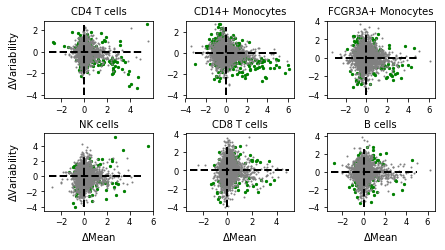

In [64]:
plt.figure(figsize=(7, 3.5))
plt.subplots_adjust(hspace=0.45, wspace=0.3)
for idx, ct in enumerate(cts):
    plt.subplot(2, 3, idx+1)
    plot_de_dv(ct, test_dict)
plt.savefig('de_vs_dv_quadrants.pdf', bbox_inches='tight')

### Expression changes across CT for a gene

In [20]:
adata.var['num'] = np.arange(adata.shape[1])

In [21]:
adata.var.loc['IFI6']

gene_ids    ENSG00000126709
n_counts    59361          
n_cells     2457           
num         66             
Name: IFI6, dtype: object

In [32]:
parameter_dict['CD4 T cells' + ' - ctrl']

{'mean': array([0.11641452, 0.448196  , 0.8653453 , ..., 0.56849104, 0.2658132 ,
        0.40745094], dtype=float32),
 'log_mean': array([-2.150598  , -0.8025247 , -0.14462666, ..., -0.56476974,
        -1.3249614 , -0.8978347 ], dtype=float32),
 'residual_var': array([3.75603655, 2.0069145 , 2.94908531, ..., 2.53497887, 1.12987436,
        1.90244249]),
 'log_residual_var': array([1.32336429, 0.69659847, 1.08149506, ..., 0.9301853 , 0.12210644,
        0.64313858])}

In [102]:
def plot_exp_changes_across_ct(gene, parameter_dict, ci_dict, barwidth=0.3):
    
    plt.figure(figsize=(3.5, 3))
    
    plt.subplots_adjust(hspace=0.1)
    
    groups = cts
    
    labels = ['Th', 'cM', 'ncM', 'NK', 'CD8', 'B']
    
    gene_idx = np.where(adata.var.index == gene)[0][0]
    
    ctrl_means = np.array([parameter_dict[group + ' - ctrl']['mean'][gene_idx] for group in groups])
    stim_means = np.array([parameter_dict[group + ' - stim']['mean'][gene_idx] for group in groups])
    ctrl_means_ci = np.array([ci_dict[group + ' - ctrl']['log1p_mean'][gene_idx] for group in groups])
    stim_means_ci = np.array([ci_dict[group + ' - stim']['log1p_mean'][gene_idx] for group in groups])
    
    ctrl_vars = np.array([parameter_dict[group + ' - ctrl']['residual_var'][gene_idx] for group in groups])
    stim_vars = np.array([parameter_dict[group + ' - stim']['residual_var'][gene_idx] for group in groups])
    ctrl_vars_ci = np.array([ci_dict[group + ' - ctrl']['log1p_residual_var'][gene_idx] for group in groups])
    stim_vars_ci = np.array([ci_dict[group + ' - stim']['log1p_residual_var'][gene_idx] for group in groups])
    
    ctrl_loc = np.arange(len(ctrl_means)) - barwidth/2
    stim_loc = np.arange(len(ctrl_means)) + barwidth/2
    
    plt.subplot(2, 1, 1)
    plt.title('{} Expression in response to IFN-B'.format(gene))
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_means+1), 
        width=barwidth,
        yerr=ctrl_means_ci,
        capsize=2
    )
    plt.bar(
        stim_loc, 
        np.log(stim_means+1), 
        width=barwidth,
        yerr=stim_means_ci,
        capsize=2
    )
    plt.xticks([])
    plt.legend(['control', 'IFN-B'])
    plt.ylabel('Mean')
    plt.ylim(0, max(np.log(ctrl_means+1).max(), np.log(stim_means+1).max()) + 2)
    
    plt.subplot(2, 1, 2)
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_vars+1), 
        width=barwidth,
        yerr=ctrl_vars_ci,
        capsize=2
    )
    plt.bar(
        stim_loc, 
        np.log(stim_vars+1), 
        width=barwidth,
        yerr=stim_vars_ci,
        capsize=2
    )
    plt.xticks(np.arange(len(ctrl_means)), labels)
    plt.ylim(0, max(np.log(ctrl_vars+1).max(), np.log(stim_vars+1).max()) + 1)
    plt.ylabel('Variability')

In [189]:
across_ct_genes = ['TNFSF10', 'IFI44L', 'TRIM22']

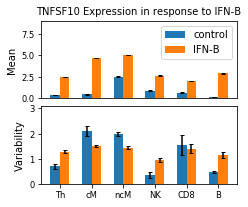

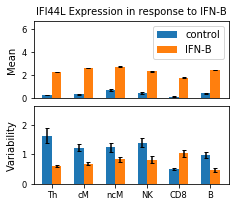

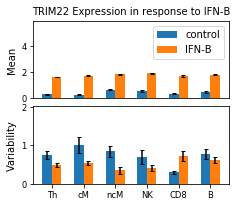

In [195]:
for gene in across_ct_genes:
    try:
        plot_exp_changes_across_ct(gene, parameter_dict, ci_dict)
    except:
        continue
    plt.savefig('de_dv_across_ct_{}.pdf'.format(gene), bbox_inches='tight')

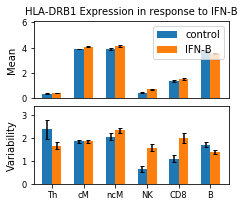

In [104]:
plot_exp_changes_across_ct('HLA-DRB1', parameter_dict, ci_dict)
plt.savefig('de_dv_across_ct_{}.pdf'.format('HLA-DRB1'), bbox_inches='tight')

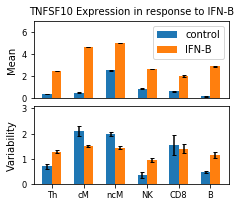

In [103]:
plot_exp_changes_across_ct('TNFSF10', parameter_dict, ci_dict)
plt.savefig('de_dv_across_ct_{}.pdf'.format('TNFSF10'), bbox_inches='tight')

### Concrete example

In [ ]:
def plot_exp_across_genes(genes, ct, parameter_dict, ci_dict, barwidth=0.3):
    
    genes_idx = [np.where(adata.var.index == gene)[0][0] for gene in genes]
    
    ctrl_means = np.array([parameter_dict[ct + ' - ctrl']['mean'][gene_idx] for gene_idx in genes_idx])
    stim_means = np.array([parameter_dict[ct + ' - stim']['mean'][gene_idx] for gene_idx in genes_idx])
    ctrl_means_ci = np.array([ci_dict[ct + ' - ctrl']['log1p_mean'][gene_idx] for gene_idx in genes_idx])
    stim_means_ci = np.array([ci_dict[ct + ' - stim']['log1p_mean'][gene_idx] for gene_idx in genes_idx])

    ctrl_vars = np.array([parameter_dict[ct + ' - ctrl']['residual_var'][gene_idx] for gene_idx in genes_idx])
    stim_vars = np.array([parameter_dict[ct + ' - stim']['residual_var'][gene_idx] for gene_idx in genes_idx])
    ctrl_vars_ci = np.array([ci_dict[ct + ' - ctrl']['log1p_residual_var'][gene_idx] for gene_idx in genes_idx])
    stim_vars_ci = np.array([ci_dict[ct + ' - stim']['log1p_residual_var'][gene_idx] for gene_idx in genes_idx])
    
    ctrl_loc = np.arange(len(ctrl_means)) - barwidth/2
    stim_loc = np.arange(len(ctrl_means)) + barwidth/2
    labels = genes
    
    plt.subplot(2, 1, 1)
    #plt.title('Upregulated genes in \n{}'.format(ct))
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_means+1), 
        width = barwidth,
        yerr=ctrl_means_ci,
        capsize=2
    )
    plt.bar(
        stim_loc, 
        np.log(stim_means+1), 
        width = barwidth,
        yerr=stim_means_ci,
        capsize=2
    )
    plt.ylim(0, max(np.log(ctrl_means+1).max(), np.log(stim_means+1).max()) + 0.5)
    plt.xticks([])
#     plt.legend(['ctrl', 'IFN'], loc='upper right')
    plt.ylabel('Mean')
    
    plt.subplot(2, 1, 2)
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_vars+1), 
        width = barwidth,
        yerr=ctrl_vars_ci,
        capsize=2
    )
    plt.bar(
        stim_loc, 
        np.log(stim_vars+1), 
        width = barwidth,
        yerr=stim_vars_ci,
        capsize=2
    )
    plt.ylim(0, max(np.log(ctrl_vars+1).max(), np.log(stim_vars+1).max()) + 0.2)
    plt.xticks(np.arange(len(ctrl_means)), labels)
    plt.ylabel('Variability')

def get_data(ct, gene_idx):
    
    return\
        (adata[adata.obs.cell_type == (ct + ' - ctrl'), :][:, gene_idx].X,
        adata[adata.obs.cell_type == (ct + ' - stim'), :][:, gene_idx].X)

def get_freq(obs, offset=False, log=False):
    
    freq = np.bincount(obs.astype(int)).astype(float)#/obs.shape[0]
    if log:
        freq = np.log(freq+1)
    #freq /= obs.shape[0]
    if offset:
        #x-=0.5
        return np.arange(freq.shape[0]+1)-.5, np.insert(freq, 0, freq[0])
    else:
        return np.arange(freq.shape[0]), freq

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    y_smooth[0] = y[0]
    return y_smooth

def get_mask(freqs):
    """ Get a monotonically decreasing mask """
    mask = []
    for idx, item in enumerate(freqs):
        if item >= freqs[idx:].max():
            mask.append(item)
        else:
            mask.append(mask[-1])
    return mask

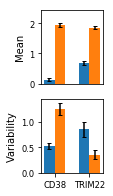

In [70]:
genes = ['CD38', 'TRIM22']
ct = 'FCGR3A+ Monocytes'
plt.figure(figsize=(1.1, 3))

plot_exp_across_genes(genes, ct, parameter_dict, ci_dict, barwidth=0.3)
plt.savefig('concrete_example_ncm_cd38_trim22.pdf', bbox_inches='tight')

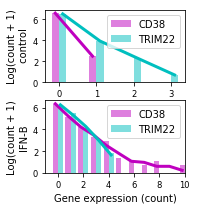

In [467]:
#x, freq = get_freq(data_2[1], log=True)

data_1 = get_data(ct, genes[0])
data_2 = get_data(ct, genes[1])

plt.figure(figsize=(2.5, 3))
plt.subplots_adjust(hspace=0.25)
plt.subplot(2, 1, 1)

freq_1 = get_freq(data_1[0], log=True);
freq_2 = get_freq(data_2[0], log=True);
mask_1 = freq_1[1]
mask_2 = freq_2[1]
plt.bar(freq_1[0]-0.1, freq_1[1], alpha=0.5, width=0.2, color='m', label=genes[0]);
plt.plot(freq_1[0]-0.1, mask_1, color='m', lw='3')
plt.bar(freq_2[0]+0.1, freq_2[1], alpha=0.5, width=0.2, color='c', label=genes[1]);
plt.plot(freq_2[0]+0.1, mask_2, color='c', lw='3')
plt.ylabel('Log(count + 1)\n control')
plt.legend()


ax = plt.subplot(2, 1, 2)
freq_1 = get_freq(data_1[1], log=True)
freq_2 = get_freq(data_2[1], log=True)
mask_1 = smooth(freq_1[1], 3)#get_mask(freq_1[1])
mask_2 = smooth(freq_2[1], 3)#get_mask(freq_2[1])
plt.bar(freq_1[0]-0.2, freq_1[1], alpha=0.5, width=0.4, color='m', label=genes[0]);
plt.plot(freq_1[0]-0.2, mask_1, color='m', lw='3')
plt.bar(freq_2[0]+0.2, freq_2[1], alpha=0.5, width=0.4, color='c', label=genes[1]);
plt.plot(freq_2[0]+0.2, mask_2, color='c', lw='3')


plt.ylabel('Log(count + 1)\nIFN-B')
plt.xlabel('Gene expression (count)')
plt.legend()
plt.xlim(-1, 10);

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('concrete_example_ncm_cd38_trim22.pdf.pdf', bbox_inches='tight')

# MAYBE

In [74]:
ctrl, stim = get_data('CD4 T cells', 'FASLG')

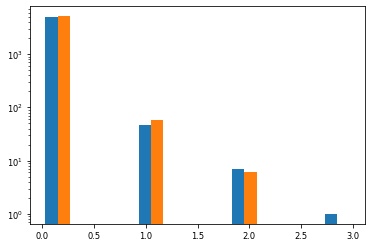

In [75]:
plt.hist([ctrl, stim])
plt.yscale('log')

### Expression changes across different genes for a CT

In [65]:
def plot_exp_across_genes(genes, ct, parameter_dict, ci_dict, barwidth=0.3):
    
    genes_idx = [np.where(adata.var.index == gene)[0][0] for gene in genes]
    
    ctrl_means = np.array([parameter_dict[ct + ' - ctrl']['mean'][gene_idx] for gene_idx in genes_idx])
    stim_means = np.array([parameter_dict[ct + ' - stim']['mean'][gene_idx] for gene_idx in genes_idx])
    ctrl_means_ci = np.array([ci_dict[ct + ' - ctrl']['log1p_mean'][gene_idx] for gene_idx in genes_idx])
    stim_means_ci = np.array([ci_dict[ct + ' - stim']['log1p_mean'][gene_idx] for gene_idx in genes_idx])

    ctrl_vars = np.array([parameter_dict[ct + ' - ctrl']['residual_var'][gene_idx] for gene_idx in genes_idx])
    stim_vars = np.array([parameter_dict[ct + ' - stim']['residual_var'][gene_idx] for gene_idx in genes_idx])
    ctrl_vars_ci = np.array([ci_dict[ct + ' - ctrl']['log1p_residual_var'][gene_idx] for gene_idx in genes_idx])
    stim_vars_ci = np.array([ci_dict[ct + ' - stim']['log1p_residual_var'][gene_idx] for gene_idx in genes_idx])
    
    ctrl_loc = np.arange(len(ctrl_means)) - barwidth/2
    stim_loc = np.arange(len(ctrl_means)) + barwidth/2
    labels = genes
    
    plt.subplot(2, 1, 1)
    #plt.title('Upregulated genes in \n{}'.format(ct))
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_means+1), 
        width = barwidth,
        yerr=ctrl_means_ci,
        capsize=2
    )
    plt.bar(
        stim_loc, 
        np.log(stim_means+1), 
        width = barwidth,
        yerr=stim_means_ci,
        capsize=2
    )
    plt.ylim(0, max(np.log(ctrl_means+1).max(), np.log(stim_means+1).max()) + 0.5)
    plt.xticks([])
#     plt.legend(['ctrl', 'IFN'], loc='upper right')
    plt.ylabel('Mean')
    
    plt.subplot(2, 1, 2)
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_vars+1), 
        width = barwidth,
        yerr=ctrl_vars_ci,
        capsize=2
    )
    plt.bar(
        stim_loc, 
        np.log(stim_vars+1), 
        width = barwidth,
        yerr=stim_vars_ci,
        capsize=2
    )
    plt.ylim(0, max(np.log(ctrl_vars+1).max(), np.log(stim_vars+1).max()) + 0.2)
    plt.xticks(np.arange(len(ctrl_means)), labels)
    plt.ylabel('Variability')

def get_data(ct, gene_idx):
    
    return\
        (adata[adata.obs.cell_type == (ct + ' - ctrl'), :][:, gene_idx].X,
        adata[adata.obs.cell_type == (ct + ' - stim'), :][:, gene_idx].X)

def get_freq(obs, offset=False, log=False):
    
    freq = np.bincount(obs.astype(int)).astype(float)#/obs.shape[0]
    if log:
        freq = np.log(freq+1)
    #freq /= obs.shape[0]
    if offset:
        #x-=0.5
        return np.arange(freq.shape[0]+1)-.5, np.insert(freq, 0, freq[0])
    else:
        return np.arange(freq.shape[0]), freq

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    y_smooth[0] = y[0]
    return y_smooth

def get_mask(freqs):
    """ Get a monotonically decreasing mask """
    mask = []
    for idx, item in enumerate(freqs):
        if item >= freqs[idx:].max():
            mask.append(item)
        else:
            mask.append(mask[-1])
    return mask

In [65]:
['TNFSF10', 'OAS1']
['CD38', 'TRIM22']

['CD38', 'TRIM22']

In [323]:
ct = 'FCGR3A+ Monocytes'
val = 2.180286
diff = 0.4
isgf3_df.query('ct == "{}" & log_mean_2 > {} & log_mean_2 < {}'.format(ct, val-diff, val+diff))#.sort_values('log_mean_2', ascending=False).head(30)

,gene,ct,log_mean_1,log_mean_2,log_residual_var_1,log_residual_var_2,de_diff,de_pval,de_fdr,dv_diff,dv_pval,dv_fdr,quadrant
435,EIF2AK2,FCGR3A+ Monocytes,0.053996,2.275475,1.324833,-0.468234,2.221479,1.657629e-07,0.000002,-1.793066,0.00207,0.046119,lower_right
628,SP110,FCGR3A+ Monocytes,0.890243,2.269483,0.188740,-0.961244,1.379240,1.684390e-07,0.000002,-1.149984,0.00617,0.087354,lower_right
2893,XAF1,FCGR3A+ Monocytes,0.501308,2.177653,0.194374,-0.750640,1.676345,1.009476e-08,0.000001,-0.945014,0.00746,0.097846,lower_right


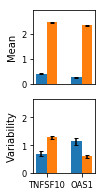

In [462]:
genes = ['TNFSF10', 'OAS1']
ct = 'CD4 T cells'
plt.figure(figsize=(1.1, 3))

plot_exp_across_genes(genes, ct, parameter_dict, ci_dict, barwidth=0.3)
plt.savefig('concrete_example_CD4_tnfsf10_oas1.pdf', bbox_inches='tight')

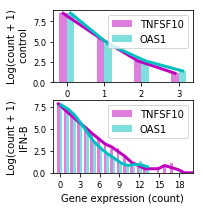

In [463]:
#x, freq = get_freq(data_2[1], log=True)

data_1 = get_data(ct, genes[0])
data_2 = get_data(ct, genes[1])

plt.figure(figsize=(2.5, 3))
plt.subplots_adjust(hspace=0.25)
plt.subplot(2, 1, 1)

freq_1 = get_freq(data_1[0], log=True);
freq_2 = get_freq(data_2[0], log=True);
mask_1 = freq_1[1]
mask_2 = freq_2[1]
plt.bar(freq_1[0]-0.1, freq_1[1], alpha=0.5, width=0.2, color='m', label=genes[0]);
plt.plot(freq_1[0]-0.1, mask_1, color='m', lw='3')
plt.bar(freq_2[0]+0.1, freq_2[1], alpha=0.5, width=0.2, color='c', label=genes[1]);
plt.plot(freq_2[0]+0.1, mask_2, color='c', lw='3')
plt.ylabel('Log(count + 1)\n control')
plt.legend()


ax = plt.subplot(2, 1, 2)
freq_1 = get_freq(data_1[1], log=True)
freq_2 = get_freq(data_2[1], log=True)
mask_1 = smooth(freq_1[1], 3)#get_mask(freq_1[1])
mask_2 = smooth(freq_2[1], 3)#get_mask(freq_2[1])
plt.bar(freq_1[0]-0.2, freq_1[1], alpha=0.5, width=0.4, color='m', label=genes[0]);
plt.plot(freq_1[0]-0.2, mask_1, color='m', lw='3')
plt.bar(freq_2[0]+0.2, freq_2[1], alpha=0.5, width=0.4, color='c', label=genes[1]);
plt.plot(freq_2[0]+0.2, mask_2, color='c', lw='3')


plt.ylabel('Log(count + 1)\nIFN-B')
plt.xlabel('Gene expression (count)')
plt.legend()
plt.xlim(-1, 20);

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('concrete_example_CD4_hist_tnfsf10_oas1.pdf', bbox_inches='tight')

In [482]:
n_unique = []
dat = adata.X.toarray()
for i in range(adata.X.shape[1]):
    
    if i % 500 == 0:
        print(i)
    n_unique.append(len(set(dat[:, i])))

0
500
1000
1500
2000
2500
3000
3500


In [484]:
a = np.array(n_unique)

In [490]:
a.mean()

10.823545783467853

In [489]:
np.median(a)

8.0

(array([ 431., 1544.,  671.,  461.,  128.,   98.,   55.,   21.,   34.,
          23.]),
 array([ 3. ,  5.6,  8.2, 10.8, 13.4, 16. , 18.6, 21.2, 23.8, 26.4, 29. ]),
 <a list of 10 Patch objects>)

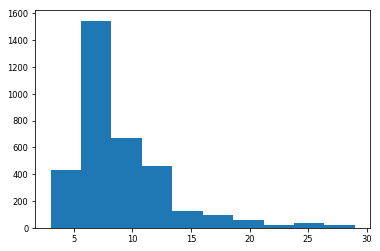

In [488]:
plt.hist(a[a < 30])

In [466]:
from matplotlib.ticker import MaxNLocator

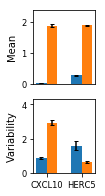

In [582]:
genes = ['CXCL10', 'HERC5']
ct = 'CD4 T cells'
plt.figure(figsize=(1.1, 3))

plot_exp_across_genes(genes, ct, parameter_dict, ci_dict, barwidth=0.3)
plt.savefig('concrete_example_CD4.pdf', bbox_inches='tight')

In [485]:
data_1 = get_data('CD4 T cells', 'CXCL10')
data_2 = get_data('CD4 T cells', 'HERC5')

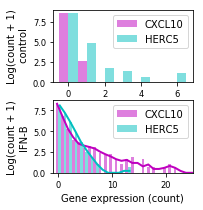

In [583]:
#x, freq = get_freq(data_2[1], log=True)
plt.figure(figsize=(2.5, 3))
plt.subplots_adjust(hspace=0.25)
plt.subplot(2, 1, 1)
freq_1 = get_freq(data_1[0], log=True);
freq_2 = get_freq(data_2[0], log=True);
plt.bar(freq_1[0]-0.25, freq_1[1], alpha=0.5, width=0.5, color='m', label='CXCL10');
plt.bar(freq_2[0]+0.25, freq_2[1], alpha=0.5, width=0.5, color='c', label='HERC5');
plt.ylabel('Log(count + 1)\n control')
plt.legend()


plt.subplot(2, 1, 2)
freq_1 = get_freq(data_1[1], log=True)
freq_2 = get_freq(data_2[1], log=True)
mask_1 = smooth(freq_1[1], 3)#get_mask(freq_1[1])
mask_2 = smooth(freq_2[1], 3)#get_mask(freq_2[1])
plt.bar(freq_1[0]-0.25, freq_1[1], alpha=0.5, width=0.5, color='m', label='CXCL10');
plt.plot(freq_1[0]-0.25, mask_1, color='m', lw='2')
plt.bar(freq_2[0]+0.25, freq_2[1], alpha=0.5, width=0.5, color='c', label='HERC5');
plt.plot(freq_2[0]+0.25, mask_2, color='c', lw='2')
plt.ylabel('Log(count + 1)\nIFN-B')
plt.xlabel('Gene expression (count)')
plt.legend()
plt.xlim(-1, 25);
plt.savefig('concrete_example_CD4_hist.pdf', bbox_inches='tight')

### ISGF3 vs IRF1/2 upregulated genes

This works, but only very few genes remain.

In [262]:
# Read the all gene information
window_size = 1000
gene_sites = pd.read_csv('all_gene_locations_2.bed', sep='\t')
gene_sites['tss_site'] = gene_sites['txStart']*(gene_sites['strand'] == '+') + gene_sites['txEnd']*(gene_sites['strand'] == '-')
gene_sites['tss_window_start'] = gene_sites['tss_site'] - int(window_size/2)
gene_sites['tss_window_end'] = gene_sites['tss_site'] + int(window_size/2)
gene_sites['tss_window_start'] = gene_sites['tss_window_start']*(gene_sites['tss_window_start'] > 0)

gene_sites['gene_name'] = gene_sites['#name'].apply(simplify_name)

gene_sites = gene_sites[['chrom', 'tss_window_start', 'tss_window_end', 'gene_name']].sort_values(['chrom', 'tss_window_start'])
gene_sites.to_csv(data_path + 'chipseq/gene_tss_windows.bed', index=False, header=False, sep='\t')

In [246]:
!/home/mkim7/tools/bedtools closest \
    -a /data/parameter_estimation/interferon_data/20200408/chipseq/selected_irf/irf1_irf2_peaks.sorted.bed \
    -b /data/parameter_estimation/interferon_data/20200408/chipseq/gene_tss_windows.bed -d  > \
    /data/parameter_estimation/interferon_data/20200408/chipseq/selected_irf/selected_irf_genes.bed

In [263]:
irf_df = pd.read_csv(data_path + 'chipseq/selected_irf/selected_irf_genes.bed', sep='\t', header=None).iloc[:, [-2, -1]]
irf_df.columns=['gene_name', 'distance']
irf_df = irf_df.query('distance == 0')
irf_df = irf_df.merge(highcount_genes[['gene_name', 'gene_ids', 'gene']], on='gene_name', how='inner')
irf_genes = irf_df['gene'].drop_duplicates().tolist()

In [265]:
ct_dfs = []
for ct in ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']:
    
    # Get upregulated genes
    upreg_genes = utils.get_differential_genes(
        gene_list=adata.var.index.tolist(),
        hypothesis_test_dict=test_dict,
        group_1 = get_key(ct)[0],
        group_2 = get_key(ct)[1],
        which='mean',
        direction='increase',
        sig=0.05,
        num_genes=5000
        )['gene'].tolist()
    
    # Filter the ISGF3 and IRF lists
    isgf3_upreg_genes = list(set(isgf3_genes) & set(upreg_genes))
    irf_upreg_genes = list(set(irf_genes) & set(upreg_genes))
    
    isgf3_only_upreg_genes = list(set(isgf3_upreg_genes) - set(irf_upreg_genes))
    irf_only_upreg_genes = list(set(irf_upreg_genes) - set(isgf3_upreg_genes))
    
    # Get idxs
    isgf3_upreg_idxs = np.where(np.isin(adata.var.index, isgf3_only_upreg_genes))[0]
    irf_upreg_idxs = np.where(np.isin(adata.var.index, irf_only_upreg_genes))[0]
    
    dv_diffs_isre_gas = test_dict[get_key(ct)]['dv_diff'][isgf3_upreg_idxs]
    dv_fdr_isre_gas = test_dict[get_key(ct)]['dv_fdr'][isgf3_upreg_idxs]
    dv_diffs_upreg = test_dict[get_key(ct)]['dv_diff'][irf_upreg_idxs]
    dv_fdr_upreg = test_dict[get_key(ct)]['dv_fdr'][irf_upreg_idxs]
    
    dv_diffs_isre_gas = dv_diffs_isre_gas#[dv_fdr_isre_gas < 1]
    dv_diffs_upreg = dv_diffs_upreg#[dv_fdr_upreg < 1]
    
    isre_gas_df = pd.DataFrame()
    isre_gas_df['dv_diff'] = dv_diffs_isre_gas
    isre_gas_df['dv_fdr'] = dv_fdr_isre_gas
    isre_gas_df['type'] = 'ISGF3'
    
    upreg_df = pd.DataFrame()
    upreg_df['dv_diff'] = dv_diffs_upreg
    upreg_df['dv_fdr'] = dv_fdr_upreg
    upreg_df['type'] = 'IRF'
    
    combined_df = pd.concat([isre_gas_df, upreg_df])
    combined_df['cell_type'] = ct
    ct_dfs.append(combined_df.copy())
    
#     plt.figure()
#     plt.title(ct)
#     sns.distplot(dv_diffs_isre_gas[np.isfinite(dv_diffs_isre_gas)])
#     sns.distplot(dv_diffs_upreg[np.isfinite(dv_diffs_upreg)])
    print('---')
    print(len(isgf3_only_upreg_genes), len(irf_only_upreg_genes))
    print(
        dv_diffs_isre_gas[np.isfinite(dv_diffs_isre_gas)].mean(),
        dv_diffs_upreg[np.isfinite(dv_diffs_upreg)].mean(),
        ct, 
        stats.ks_2samp(
            dv_diffs_isre_gas[np.isfinite(dv_diffs_isre_gas)], 
            dv_diffs_upreg[np.isfinite(dv_diffs_upreg)]))
isgf3_irf_comparison_df = pd.concat(ct_dfs)
#cts = ['CD4 T cells', 'CD8 T cells', 'NK cells', 'B cells', 'CD14+ Monocytes', 'FCGR3A+ Monocytes']

#isre_gas_comparison_df = isre_gas_comparison_df[isre_gas_comparison_df['cell_type'].isin(cts)]

---
17 202
-0.2954379068379633 -0.059561022229836016 CD4 T cells Ks_2sampResult(statistic=0.23733255678509027, pvalue=0.290675699802455)
---
17 190
-0.41592892554649347 -0.14974473975006555 CD14+ Monocytes Ks_2sampResult(statistic=0.33560371517027865, pvalue=0.045242087299503075)
---
16 145
-0.6918284207597869 0.12856528279621 FCGR3A+ Monocytes Ks_2sampResult(statistic=0.45991379310344827, pvalue=0.002779966910325893)
---
13 90
-0.6159506167793527 -0.007981150827508336 NK cells Ks_2sampResult(statistic=0.38290598290598293, pvalue=0.04996475026181413)
---
15 88
-0.12538987118188769 0.07185715609425475 CD8 T cells Ks_2sampResult(statistic=0.2196969696969697, pvalue=0.4893000635846113)
---
18 128
-0.3664578513336924 0.032110590820097346 B cells Ks_2sampResult(statistic=0.2421875, pvalue=0.26308770512941293)


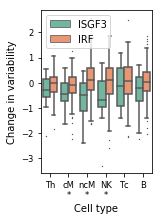

In [269]:
plt.figure(figsize=(2, 3))
sns.boxplot(
    x='cell_type', y='dv_diff', hue='type',
    data=isgf3_irf_comparison_df,
    palette=sns.color_palette('Set2'),
    fliersize=0.5)
#plt.plot([-1, 6], [0, 0], '--', lw=1, color='k')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['Th', 'cM\n*', 'ncM\n*', 'NK\n*', 'Tc', 'B'])
plt.xlabel('Cell type'); plt.ylabel('Change in variability');
plt.legend(loc='upper left')
plt.savefig('isgf3_vs_irf.pdf', bbox_inches='tight')